# xG Model Testing and Evaluation

This notebook will test calling functions from imported Python scripts. An evaluation of two complete NHL season data will follow.  

In [1]:
import pandas as pd
import hockey_scraper
import numpy as np
import math
import seaborn as sns
from tqdm.notebook import tqdm # This displays a loading bar for monitoring progress of for loops

In [2]:
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    mean_absolute_percentage_error,
    mean_squared_error,
    log_loss,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
from xG_Model_v1dot0 import get_xG, return_feature_cols

In [4]:
shots2022 = pd.read_csv('shots2022.csv')
shots2021 = pd.read_csv('shots2021.csv')

In [5]:
allshots = pd.concat([shots2021,shots2022])
allshots = allshots.reset_index(drop=True)
allshots

,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,Type,...,Home_Goalie_Id,xC,yC,Home_Coach,Away_Coach,Distance,Shot_Angle,Score_Diff,Is_Rebound,Change_of_Angle
0,20001,2021-10-12,1,SHOT,"TBL ONGOAL - #91 STAMKOS, Wrist, Off. Zone, 42...",1:03,63,5x5,Off,WRIST SHOT,...,8476883.0,61,-32,Jon Cooper,Mike Sullivan,42.520583,48.814075,0,0,NaN
1,20001,2021-10-12,1,BLOCK,"TBL #24 BOGOSIAN BLOCKED BY PIT #23 MCGINN, W...",1:25,85,5x5,Def,WRIST SHOT,...,8476883.0,60,-17,Jon Cooper,Mike Sullivan,33.615473,30.379126,0,0,NaN
2,20001,2021-10-12,1,SHOT,"PIT ONGOAL - #23 MCGINN, Wrist, Off. Zone, 30 ft.",1:44,104,5x5,Off,WRIST SHOT,...,8476883.0,-65,19,Jon Cooper,Mike Sullivan,30.610456,38.367485,0,0,NaN
3,20001,2021-10-12,1,SHOT,"TBL ONGOAL - #44 RUTTA, Wrist, Neu. Zone, 100 ft.",2:01,121,5x5,Neu,WRIST SHOT,...,8476883.0,-8,-27,Jon Cooper,Mike Sullivan,100.687636,15.554571,0,0,NaN
4,20001,2021-10-12,1,SHOT,"PIT ONGOAL - #43 HEINEN, Wrist, Off. Zone, 29 ft.",2:47,167,5x5,Off,WRIST SHOT,...,8476883.0,-60,-4,Jon Cooper,Mike Sullivan,29.274562,7.853313,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300869,21312,2023-04-13,3,SHOT,"SEA ONGOAL - #67 GEEKIE, Wrist, Off. Zone, 10 ft.",17:14,1034,5x5,Off,WRIST SHOT,...,8475831.0,81,7,Dave Hakstol,Bruce Cassidy,10.630146,41.185925,-1,1,10.535257
300870,21312,2023-04-13,3,MISS,"VGK #9 EICHEL, Wrist, Wide of Net, Def. Zone, ...",18:33,1113,5x5,Def,WRIST SHOT,...,NaN,55,41,Dave Hakstol,Bruce Cassidy,149.723078,15.892831,1,0,NaN
300871,21312,2023-04-13,3,BLOCK,"SEA #4 SCHULTZ BLOCKED BY VGK #3 MCNABB, Wris...",18:43,1123,5x5,Def,WRIST SHOT,...,NaN,75,-1,Dave Hakstol,Bruce Cassidy,14.035669,4.085617,-1,0,NaN
300872,21312,2023-04-13,3,GOAL,"VGK #20 STEPHENSON(16), Poke, Def. Zone, 137 ft.",19:22,1162,5x5,Def,POKE,...,NaN,47,19,Dave Hakstol,Bruce Cassidy,137.320792,7.953082,1,0,NaN


In [6]:
model_columns = ['Strength','Period','Type','Distance','Shot_Angle','Score_Diff',
                 'Is_Rebound','Change_of_Angle']
eval_columns = ['Game_Id','Date','Period','Seconds_Elapsed','Event','Description','Time_Elapsed','Ev_Zone','Ev_Team','Home_Zone','Away_Team',
                'Home_Team','p1_name','p1_ID','p2_name','p2_ID','p3_name','p3_ID','awayPlayer1','awayPlayer1_id',
                'awayPlayer2','awayPlayer2_id','awayPlayer3','awayPlayer3_id','awayPlayer4','awayPlayer4_id','awayPlayer5',
                'awayPlayer5_id','awayPlayer6','awayPlayer6_id','homePlayer1','homePlayer1_id','homePlayer2',
                'homePlayer2_id','homePlayer3','homePlayer3_id','homePlayer4','homePlayer4_id','homePlayer5',
                'homePlayer5_id','homePlayer6','homePlayer6_id','Away_Players','Home_Players','Away_Score','Home_Score',
                'Away_Goalie','Away_Goalie_Id','Home_Goalie','Home_Goalie_Id','xC','yC','Home_Coach','Away_Coach']

In [7]:
numeric_feats = ['Distance','Shot_Angle','Change_of_Angle']  # apply scaling
categorical_feats = ['Strength','Type','Score_Diff','Is_Rebound']  # apply one-hot encoding

In [8]:
model_df = allshots[model_columns]
eval_df = allshots[eval_columns]

In [9]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(sparse_output=False), categorical_feats), # one-hot encoding on categorical features
)

In [10]:
# Train Data

transformed = ct.fit_transform(model_df)
column_names = (numeric_feats+ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
test_df = pd.DataFrame(transformed, columns=column_names)

imp = SimpleImputer(strategy='constant',fill_value=0)
imp.fit(test_df)
temp = imp.transform(test_df)
df = pd.DataFrame(temp)
test_df['Change_of_Angle'] = df[3]
test_df

,Distance,Shot_Angle,Change_of_Angle,Strength_2x5,Strength_3x3,Strength_3x4,Strength_3x5,Strength_4x3,Strength_4x4,Strength_4x5,...,Type_WRIST SHOT,Score_Diff_-1,Score_Diff_-2,Score_Diff_-3-,Score_Diff_0,Score_Diff_1,Score_Diff_2,Score_Diff_3+,Is_Rebound_0,Is_Rebound_1
0,0.424908,0.994410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.037099,0.123084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.093767,0.500653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.958033,-0.577598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.151944,-0.941598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300869,-0.963892,0.633866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300870,5.093484,-0.561610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
300871,-0.815585,-1.119678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
300872,4.553375,-0.936882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
frame = [test_df,eval_df]
shots = pd.concat(frame,axis=1)
shots

,Distance,Shot_Angle,Change_of_Angle,Strength_2x5,Strength_3x3,Strength_3x4,Strength_3x5,Strength_4x3,Strength_4x4,Strength_4x5,...,Away_Score,Home_Score,Away_Goalie,Away_Goalie_Id,Home_Goalie,Home_Goalie_Id,xC,yC,Home_Coach,Away_Coach
0,0.424908,0.994410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,TRISTAN JARRY,8477465.0,ANDREI VASILEVSKIY,8476883.0,61,-32,Jon Cooper,Mike Sullivan
1,0.037099,0.123084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,TRISTAN JARRY,8477465.0,ANDREI VASILEVSKIY,8476883.0,60,-17,Jon Cooper,Mike Sullivan
2,-0.093767,0.500653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,TRISTAN JARRY,8477465.0,ANDREI VASILEVSKIY,8476883.0,-65,19,Jon Cooper,Mike Sullivan
3,2.958033,-0.577598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,TRISTAN JARRY,8477465.0,ANDREI VASILEVSKIY,8476883.0,-8,-27,Jon Cooper,Mike Sullivan
4,-0.151944,-0.941598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,TRISTAN JARRY,8477465.0,ANDREI VASILEVSKIY,8476883.0,-60,-4,Jon Cooper,Mike Sullivan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300869,-0.963892,0.633866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,LAURENT BROSSOIT,8476316.0,PHILIPP GRUBAUER,8475831.0,81,7,Dave Hakstol,Bruce Cassidy
300870,5.093484,-0.561610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,LAURENT BROSSOIT,8476316.0,NaN,NaN,55,41,Dave Hakstol,Bruce Cassidy
300871,-0.815585,-1.119678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,LAURENT BROSSOIT,8476316.0,NaN,NaN,75,-1,Dave Hakstol,Bruce Cassidy
300872,4.553375,-0.936882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,LAURENT BROSSOIT,8476316.0,NaN,NaN,47,19,Dave Hakstol,Bruce Cassidy


In [12]:
cols = return_feature_cols()

In [13]:
# Test Cell

get_xG(shots.iloc[[1]][cols])

0.03618757882720002

### Making Player Name to ID Dictionary

In [14]:
name_id = {}

on_ice_player_ids = ['awayPlayer1_id','awayPlayer2_id','awayPlayer3_id','awayPlayer4_id','awayPlayer5_id','awayPlayer6_id',
                     'homePlayer1_id','homePlayer2_id','homePlayer3_id','homePlayer4_id','homePlayer5_id','homePlayer6_id']
on_ice_player_names = ['awayPlayer1','awayPlayer2','awayPlayer3','awayPlayer4','awayPlayer5','awayPlayer6',
                        'homePlayer1','homePlayer2','homePlayer3','homePlayer4','homePlayer5','homePlayer6']

context_ids = ['p1_ID','p2_ID','p3_ID','Away_Goalie_Id','Home_Goalie_Id']
context_names = ['p1_name','p2_name','p3_name','Away_Goalie','Home_Goalie']

concat_id = on_ice_player_ids + context_ids
concat_names = on_ice_player_names + context_names

In [15]:
for i in range(len(shots)):
    for j in range(len(concat_id)):
        if pd.isna(shots.at[i,concat_id[j]]) & pd.isna(shots.at[i,concat_names[j]]):
            continue
        if shots.at[i,concat_id[j]] not in name_id.keys():
            name_id.update({shots.at[i,concat_id[j]] : shots.at[i,concat_names[j]]})
    
name_id

{8478542.0: 'EVAN RODRIGUES',
 8477953.0: 'KASPERI KAPANEN',
 8475722.0: 'JASON ZUCKER',
 8478507.0: 'JOHN MARINO',
 8477969.0: 'MARCUS PETTERSSON',
 8477465.0: 'TRISTAN JARRY',
 8473986.0: 'ALEX KILLORN',
 8478519.0: 'ANTHONY CIRELLI',
 8474564.0: 'STEVEN STAMKOS',
 8474567.0: 'ZACH BOGOSIAN',
 8479410.0: 'MIKHAIL SERGACHEV',
 8476883.0: 'ANDREI VASILEVSKIY',
 8478866.0: 'DOMINIK SIMON',
 8476927.0: 'TEDDY BLUEGER',
 8476934.0: 'BROCK MCGINN',
 8475208.0: 'BRIAN DUMOULIN',
 8471724.0: 'KRIS LETANG',
 8479525.0: 'ROSS COLTON',
 8478472.0: 'MATHIEU JOSEPH',
 8470621.0: 'COREY PERRY',
 8477244.0: 'CHAD RUHWEDEL',
 8478017.0: 'MARK FRIEDMAN',
 8479390.0: 'TAYLOR RADDYSH',
 8474034.0: 'PAT MAROON',
 8477930.0: 'PIERRE-EDOUARD BELLEMARE',
 8480172.0: 'JAN RUTTA',
 8475167.0: 'VICTOR HEDMAN',
 8470619.0: 'BRIAN BOYLE',
 8478043.0: 'SAM LAFFERTY',
 8482055.0: "DREW O'CONNOR",
 8470604.0: 'JEFF CARTER',
 8475810.0: 'BRYAN RUST',
 8478046.0: 'DANTON HEINEN',
 8478010.0: 'BRAYDEN POINT',
 847629

### Evaluation

I tried to make this as fast as possible. 

In [16]:
team_eval = pd.DataFrame(columns=['Team','xG','G'])
team_eval['Team'] = list(set(shots.Ev_Team))
team_eval['xG'] = 0
team_eval['G'] = 0
team_eval = team_eval.set_index('Team').sort_values(by='Team')
team_eval

,xG,G
Team,,
ANA,0,0
ARI,0,0
BOS,0,0
BUF,0,0
CAR,0,0
CBJ,0,0
CGY,0,0
CHI,0,0
COL,0,0


In [17]:
player_eval = pd.DataFrame(columns=['Player','xG','G'])
player_eval['Player'] = list(name_id.keys())
player_eval['xG'] = 0
player_eval['G'] = 0
player_eval = player_eval.set_index('Player')
player_eval

,xG,G
Player,,
8478542.0,0,0
8477953.0,0,0
8475722.0,0,0
8478507.0,0,0
8477969.0,0,0
...,...,...
NaN,0,0
NaN,0,0
NaN,0,0


Now to make the evaluation loop. 

In [18]:
# test_df contains the features in the model
# shots contains all the info

league_xG = []
goals = 0

for i in tqdm(range(len(shots))):
    xg_val = get_xG(test_df.iloc[[i]][cols])
    team = shots.at[i,'Ev_Team']
    player = shots.at[i,'p1_ID']
    if shots.at[i,'Event'] == 'BLOCK':
        player = shots.at[i,'p2_ID']    
    league_xG.append(xg_val)
    team_eval.at[team,'xG'] = team_eval.at[team,'xG'] + xg_val
    player_eval.at[player,'xG'] = player_eval.at[player,'xG'] + xg_val
    if shots.at[i,'Event'] == 'GOAL':
        goals = goals + 1
        team_eval.at[team,'G'] = team_eval.at[team,'G'] + 1
        player_eval.at[player,'G'] = player_eval.at[player,'G'] + 1
        
player_eval

  0%|          | 0/300874 [00:00<?, ?it/s]

,xG,G
Player,,
8478542.0,40.044767,35
8477953.0,21.590491,26
8475722.0,32.556567,35
8478507.0,14.045144,5
8477969.0,13.910150,3
...,...,...
NaN,3.648081,2
NaN,3.648081,2
NaN,3.648081,2


In [19]:
player_eval = player_eval.reset_index()

for i in range(len(player_eval)):
    p_name = name_id.get(player_eval.at[i,'Player'])
    player_eval.at[i,'Player'] = p_name
    
player_eval

,Player,xG,G
0,EVAN RODRIGUES,40.044767,35
1,KASPERI KAPANEN,21.590491,26
2,JASON ZUCKER,32.556567,35
3,JOHN MARINO,14.045144,5
4,MARCUS PETTERSSON,13.910150,3
...,...,...,...
3343,None,3.648081,2
3344,None,3.648081,2
3345,None,3.648081,2
3346,None,3.648081,2


<br>

### League Overview

In [20]:
print('The model underestimates the total number of goals over two seasons by:',sum(league_xG)-goals)

The model overestimates the total number of goals over two seasons by: 193.95876390752528


This is cheating a bit as the same data that was used to train the model forms part of the evaluation data set. The trend of underestimating actual goals continues over both seasons.

<br>

### Team Overview

In [21]:
team_eval

,xG,G
Team,,
ANA,449.225435,431
ARI,407.331523,431
BOS,532.576797,550
BUF,474.840205,521
CAR,601.951953,538
CBJ,478.994720,471
CGY,583.401026,549
CHI,426.584722,414
COL,561.593742,582


In [22]:
rmse = math.sqrt(mean_squared_error(team_eval['G'],team_eval['xG']))
mape = mean_absolute_percentage_error(team_eval['G'],team_eval['xG'])
print('The RMSE across two seasons is:',rmse)
print('The MAPE across two seasons is:',mape)

The RMSE across two seasons is: 35.49711440226957
The MAPE across two seasons is: 0.05425837809411813


Across two seasons, the RMSE of the model is around 35 goals - around a 5% error. Some of the teams with the biggest discrepancies are STL, CAR, and WPG. 

<br>

### Player Overview

In [23]:
player_eval = player_eval.sort_values(by='xG',ascending=False)
player_eval = player_eval.reset_index(drop=True)
player_eval

,Player,xG,G
0,BRADY TKACHUK,78.925471,65
1,CONNOR MCDAVID,75.511543,106
2,AUSTON MATTHEWS,74.489739,99
3,MATTHEW TKACHUK,74.458749,82
4,JOHN TAVARES,74.033367,63
...,...,...,...
3343,ILYA SOROKIN,0.000000,0
3344,JACOB MARKSTROM,0.000000,0
3345,PYOTR KOCHETKOV,0.000000,0
3346,STEFAN MATTEAU,0.000000,0


In [24]:
player_eval.head(n=10)

,Player,xG,G
0,BRADY TKACHUK,78.925471,65
1,CONNOR MCDAVID,75.511543,106
2,AUSTON MATTHEWS,74.489739,99
3,MATTHEW TKACHUK,74.458749,82
4,JOHN TAVARES,74.033367,63
5,DAVID PASTRNAK,70.175433,101
6,ZACH HYMAN,70.039501,62
7,TIMO MEIER,68.971246,75
8,ALEX OVECHKIN,68.304037,92
9,LEON DRAISAITL,66.985322,107


In [25]:
rmse = math.sqrt(mean_squared_error(player_eval['G'],player_eval['xG']))
print('The RMSE across two seasons is:',rmse)

The RMSE across two seasons is: 3.8193759419843505


The RMSE across two seasons is just below 4 goals.

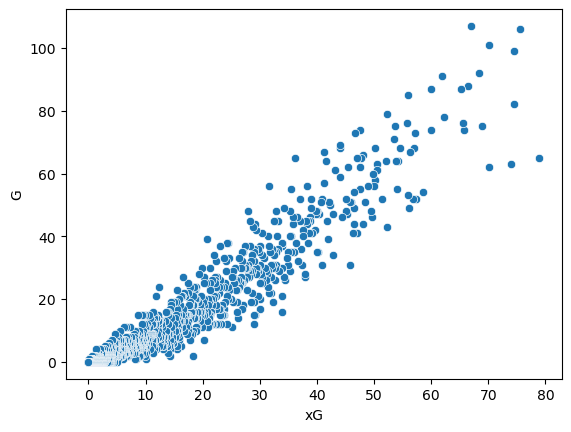

In [26]:
sns.scatterplot(x=player_eval['xG'], y=player_eval['G'])
plt.show()

<br>

## Overview

So I guess the model sort of works pretty well. For the start of the 2023-24 NHL season, the model will be trained completely on the entirety of the 2021-22 and 2022-23 NHL seasons. 

<br>

### Quick Overview of Penalty Shots/Shootouts

Penalty shots/shootouts are special situations and the xG of a penalty shot is simply the number of goals on penalty shots divided by the total number of penalty shots.

In [39]:
pbp2022 = pd.read_csv('pbp2022.csv')
pbp2021 = pd.read_csv('pbp2021.csv')
frame = [pbp2022,pbp2021]
pbp = pd.concat(frame)
penshots = pbp.loc[(pbp.Strength == '0x0') & ((pbp.Event == 'GOAL') | (pbp.Event == 'SHOT') | (pbp.Event == 'MISS'))].reset_index(drop=True)
penshots

,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,Type,...,Away_Score,Home_Score,Away_Goalie,Away_Goalie_Id,Home_Goalie,Home_Goalie_Id,xC,yC,Home_Coach,Away_Coach
0,20007,2022-10-12,2,SHOT,"TOR ONGOAL - #15 KERFOOT, Penalty Shot, Snap, ...",17:20,1040,0x0,Off,SNAP SHOT,...,2,2,NaN,NaN,JAKE ALLEN,8474596.0,-77.0,0.0,Martin St. Louis,Sheldon Keefe
1,20037,2022-10-15,2,SHOT,"VGK ONGOAL - #20 STEPHENSON, Penalty Shot, Wri...",4:37,277,0x0,Off,WRIST SHOT,...,2,0,NaN,NaN,MARTIN JONES,8474889.0,68.0,-2.0,Dave Hakstol,Bruce Cassidy
2,20060,2022-10-20,2,GOAL,"MTL #14 SUZUKI(3), Penalty Shot, Wrist, Off. Z...",18:27,1107,0x0,Off,WRIST SHOT,...,0,4,CONNOR INGRAM,8478971.0,NaN,NaN,80.0,3.0,Martin St. Louis,André Tourigny
3,20072,2022-10-21,2,GOAL,"CHI #89 ATHANASIOU(1), Penalty Shot, Snap, Off...",5:41,341,0x0,Off,SNAP SHOT,...,2,0,ALEX NEDELJKOVIC,8477968.0,NaN,NaN,76.0,1.0,Luke Richardson,Derek Lalonde
4,20101,2022-10-25,3,SHOT,"MTL ONGOAL - #68 HOFFMAN, Penalty Shot, Wrist,...",5:50,350,0x0,Off,WRIST SHOT,...,2,1,MARC-ANDRE FLEURY,8470594.0,NaN,NaN,-76.0,0.0,Martin St. Louis,Dean Evason
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,21207,2022-04-29,5,SHOT,"VAN ONGOAL - #8 GARLAND, Wrist, Off. Zone, 14 ft.",0:00,0,0x0,Off,WRIST SHOT,...,2,2,SPENCER MARTIN,8477484.0,MIKKO KOSKINEN,8475156.0,-81.0,12.0,Jay Woodcroft,Bruce Boudreau
1314,21207,2022-04-29,5,GOAL,"EDM #14 SHORE, Wrist, Off. Zone, 11 ft.",0:00,0,0x0,Off,WRIST SHOT,...,2,2,SPENCER MARTIN,8477484.0,MIKKO KOSKINEN,8475156.0,78.0,2.0,Jay Woodcroft,Bruce Boudreau
1315,21207,2022-04-29,5,SHOT,"VAN ONGOAL - #23 EKMAN-LARSSON, Wrist, Off. Zo...",0:00,0,0x0,Off,WRIST SHOT,...,2,3,SPENCER MARTIN,8477484.0,MIKKO KOSKINEN,8475156.0,-76.0,-12.0,Jay Woodcroft,Bruce Boudreau
1316,30161,2022-05-02,1,SHOT,"STL ONGOAL - #49 BARBASHEV, Penalty Shot, Wris...",3:50,230,0x0,Off,WRIST SHOT,...,0,0,NaN,NaN,MARC-ANDRE FLEURY,8470594.0,69.0,4.0,Dean Evason,Craig Berube


In [40]:
pen_g = 0
for i in range(len(penshots)):
    if penshots.at[i,'Event'] == 'GOAL':
        pen_g = pen_g + 1
        
print('Number of goals:',pen_g)
print('Number of shots:',len(penshots))
print('xG of a penalty shot attempt:',pen_g/len(penshots))

Number of goals: 415
Number of shots: 1318
xG of a penalty shot attempt: 0.3148710166919575
